# Load data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import logging
import warnings

import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import numpy as np

from datetime import datetime
from gensim.models import Word2Vec
from tqdm.notebook import tqdm
from IPython import display # live plotting

warnings.filterwarnings("ignore")
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)
logger = logging.getLogger()

In [2]:
file = open("data/python.txt", "r")
files = []
corpus_file = ''
for line in file:
    if "EOF" not in line:
        corpus_file += line
    else:
        files.append(corpus_file)
        corpus_file = ''

In [3]:
print(files[0])

Python Syntax
Last update on February 28 2020 12:16:01 (UTC/GMT +8 hours)
Introduction
A Python program is read by a parser. Python was designed to be a highly readable language. The syntax of the Python programming language is the set of rules which defines how a Python program will be written.

Python Line Structure:

A Python program is divided into a number of logical lines and every logical line is terminated by the token NEWLINE. A logical line is created from one or more physical lines.
A line contains only spaces, tabs, formfeeds possibly a comment, is known as a blank line, and Python interpreter ignores it.
A physical line is a sequence of characters terminated by an end-of-line sequence (in windows it is called CR LF or return followed by a linefeed and in Unix, it is called LF or linefeed). See the following example.

Python Line structure
 

Comments in Python:

A comment begins with a hash character(#) which is not a part of the string literal and ends at the end of the p

# Model for Generate a tutorial given a string data

In [4]:
def preprocess_data(data):
    data = data.split()
    data = [dat.lower().strip() for dat  in data]
    return ' '.join(data)

def load_data(data):
    data = preprocess_data('\n'.join(data))
    chars = tuple(set(data))
    # Look up tables
    idx2char = dict(enumerate(chars))
    char2idx = {char: idx for idx, char in idx2char.items()}
    # Encoding
    encoded = torch.tensor([char2idx[ch] for ch in data])
    return chars, encoded

In [5]:
def one_hot_encode(arr, n_labels):
    """
    One-hot encoding for character-data
    """
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)

    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.

    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))

    return one_hot


def get_batches(arr, n_seqs, n_steps):
    """
    Batch generator that returns mini-batches of size (n_seqs x n_steps)
    """
    batch_size = n_seqs * n_steps
    n_batches = len(arr) // batch_size

    # always create full batches
    arr = arr[:n_batches * batch_size]
    
    # reshape
    arr = arr.reshape((n_seqs, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        # features (sequence of characters)
        x = arr[:, n:n + n_steps]
        
        # targets (the next character after the sequence)
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n + n_steps]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [6]:
class CharRNN(nn.Module):
    def __init__(self, tokens, n_hidden=256, n_layers=2, drop_prob=0.5):
        """
        Basic implementation of a multi-layer RNN with LSTM cells and Dropout.
        """
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden

        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}

        self.dropout = nn.Dropout(drop_prob)
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers,
                            dropout=drop_prob, batch_first=True)
        self.fc = nn.Linear(n_hidden, len(self.chars))

    def forward(self, x, hidden):
        """
        Forward pass through the network
        """

        x, hidden = self.lstm(x, hidden)
        x = self.dropout(x)
        x = self.fc(x)

        return x, hidden

    def predict(self, char, hidden=None, device=torch.device('cpu'), top_k=None):
        """
        Given a character, predict the next character. Returns the predicted character and the hidden state.
        """
        with torch.no_grad():
            self.to(device)
            try:
                x = np.array([[self.char2int[char]]])
            except KeyError:
                return '', hidden

            x = one_hot_encode(x, len(self.chars))
            inputs = torch.from_numpy(x).to(device)

            out, hidden = self.forward(inputs, hidden)

            p = F.softmax(out, dim=2).data.to('cpu')

            if top_k is None:
                top_ch = np.arange(len(self.chars))
            else:
                p, top_ch = p.topk(top_k)
                top_ch = top_ch.numpy().squeeze()

            if top_k == 1:
                char = int(top_ch)
            else:
                p = p.numpy().squeeze()
                char = np.random.choice(top_ch, p=p / p.sum())

            return self.int2char[char], hidden


def save_checkpoint(net, opt, filename, train_history={}):
    """
    Save trained model to file.
    """
    checkpoint = {'n_hidden': net.n_hidden,
                  'n_layers': net.n_layers,
                  'state_dict': net.state_dict(),
                  'optimizer': opt.state_dict(),
                  'tokens': net.chars,
                  'train_history': train_history}

    with open(filename, 'wb') as f:
        torch.save(checkpoint, f)


def load_checkpoint(filename):
    """
    Load trained model from file.
    """
    with open(filename, 'rb') as f:
        checkpoint = torch.load(f, map_location='cpu')

    net = CharRNN(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
    net.load_state_dict(checkpoint['state_dict'])

    return net, checkpoint

In [7]:
plt.ion() # Allow live updates of plots

def train(net, data, epochs=10, n_seqs=10, n_steps=50, lr=0.001, clip=5, val_frac=0.1, device=torch.device('cpu'),
          name='checkpoint', early_stop=True, plot=True):
    """
    Training loop.
    """
    net.train() # switch into training mode
    opt = torch.optim.Adam(net.parameters(), lr=lr) # initialize optimizer
    criterion = nn.CrossEntropyLoss() # initialize loss function

    # create training and validation data
    val_idx = int(len(data) * (1 - val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    net.to(device) # move neural net to GPU/CPU memory
    
    min_val_loss = 10.**10 # initialize minimal validation loss
    train_history = {'epoch': [], 'step': [], 'loss': [], 'val_loss': []}

    n_chars = len(net.chars) # get size of vocabulary
    
    # main loop over training epochs
    for e in range(epochs):
        hidden = None # reste hidden state after each epoch
        
        # loop over batches
        for x, y in get_batches(data, n_seqs, n_steps):
            # encode data and create torch-tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x).to(device), torch.tensor(y, dtype=torch.long).to(device)
            
            # reset gradient information
            net.zero_grad()
            
            # generate network output
            output, hidden = net.forward(inputs, hidden)
            
            # compute loss
            loss = criterion(output.view(n_seqs * n_steps, n_chars), targets.view(n_seqs * n_steps))
            
            # compute gradients
            loss.backward()

            # gradient clipping to prevent exploding gradients
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            
            # optmize
            opt.step()

            # prevent backpropagating through the entire training history
            # by detaching hidden state and cell state
            hidden = (hidden[0].detach(), hidden[1].detach())
        
        # validation step is done without tracking gradients
        with torch.no_grad():
            val_h = None
            val_losses = []
            
            for x, y in get_batches(val_data, n_seqs, n_steps):
                x = one_hot_encode(x, n_chars)
                inputs, targets = torch.from_numpy(x).to(device), torch.tensor(y, dtype=torch.long).to(device)

                output, val_h = net.forward(inputs, val_h)
                
                val_loss = criterion(output.view(n_seqs * n_steps, n_chars), targets.view(n_seqs * n_steps))
                val_losses.append(val_loss.item())
            
            # compute mean validation loss over batches
            mean_val_loss = np.mean(val_losses)
            
            # track progress
            train_history['epoch'].append(e+1)
            train_history['loss'].append(loss.item())
            train_history['val_loss'].append(mean_val_loss)
        
        if plot:
            # create live plot of training loss and validation loss
            plt.clf()
            plt.plot(train_history['loss'], lw=2, c='C0')
            plt.plot(train_history['val_loss'], lw=2, c='C1')
            plt.xlabel('epoch')
            plt.title("{}   Epoch: {:.0f}/{:.0f}   Loss: {:.4f}   Val Loss: {:.4f}".format(
                datetime.now().strftime('%H:%M:%S'),
                e+1, epochs,
                loss.item(),
                mean_val_loss), color='k')
            display.clear_output(wait=True)
            display.display(plt.gcf())
        else:
            # print training progress
            print("{}   Epoch: {:.0f}/{:.0f}   Loss: {:.4f}   Val Loss: {:.4f}".format(
                datetime.now().strftime('%H:%M:%S'),
                e+1, epochs,
                loss.item(),
                mean_val_loss))
        
        # save model checkpoint if validation loss has decreased
        
        save_checkpoint(net, opt, name+'.net', train_history=train_history)
        min_val_loss = mean_val_loss
        
        # if validation loss has not decreased for the last 10 epochs, stop training
        if early_stop:
            if e - np.argmin(train_history['val_loss']) > 10:
                display.clear_output()
                print('Validation loss does not decrease further, stopping training.')
                break

Validation loss does not decrease further, stopping training.


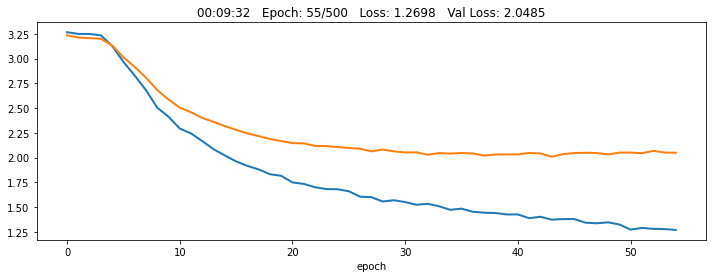

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# load data
chars, data = load_data(files)

# create RNN
net = CharRNN(chars, n_hidden=256, n_layers=3)

# train
plt.figure(figsize=(12, 4))
train(net, data, epochs=500, n_seqs=40, n_steps=40, lr=0.001, device=device, val_frac=0.1,
      name='training-blog', plot=True, early_stop=True)

In [9]:
import re

def load_checkpoint(filename):
    with open(filename, 'rb') as f:
        checkpoint = torch.load(f, map_location='cpu')

    net = CharRNN(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
    net.load_state_dict(checkpoint['state_dict'])

    train_history = checkpoint['train_history']

    return net, train_history


def sample_lines(net, n_lines=3, prime='', top_k=None, device='cpu', max_len=1000):
    net.to(device)
    net.eval()

    # First off, run through the prime characters
    chars = []
    h = None
    for ch in prime:
        char, h = net.predict(ch, h, device=device, top_k=top_k)

    chars.append(char)

    # Now pass in the previous character and get a new one
    l = 0
    for ii in range(max_len):
        char, h = net.predict(chars[-1], h, device=device, top_k=top_k)
        chars.append(char)
        if char == '\n':
            l += 1
            if l == n_lines:
                break

    return ''.join(chars)


def clean_string(x):
    x = re.sub('#.*$', '', x, flags=re.MULTILINE)
    x = re.sub("'''[\s\S]*?'''", '', x, flags=re.MULTILINE)
    x = re.sub('"""[\s\S]*?"""', '', x, flags=re.MULTILINE)
    x = re.sub('^[\t]+\n', '', x, flags=re.MULTILINE)
    x = re.sub('^[ ]+\n', '', x, flags=re.MULTILINE)
    x = re.sub('\n[\n]+', '\n\n', x, flags=re.MULTILINE)
    return x

In [10]:
net, _ = load_checkpoint('training-blog.net')

In [28]:
prime = 'python string format'

clean_prime = clean_string(prime)
print(sample_lines(net, 3, prime=clean_prime, top_k=3, max_len=600))

ting strings. see the following example collection and a string. python dictionary in python statements in python strings are immutable to the function, a python string strings in and a collection and see the following example in the following example, a tuple >>> #create the tuple to true is an an of the sum of a see the following statements in python sets is assignment in the comples of a python dictionary in python, the sequence of the language on the string, the set of strings are supports as part of the function or the same of an operator it is an expression, as a string. in python diction


In [29]:
# TODO: recollect more data, change to word rnn instead of char

# Preprocess data

In [4]:
from utils import get_regex_expression, preprocess_data

In [5]:
regex = get_regex_expression()
train_data =  [preprocess_data(file, regex, False, True) for file in tqdm(files)]

In [6]:
print(train_data[0])

['python', 'syntax', 'last', 'update', 'on', 'february', 'utc', 'gmt', 'hour', 'introduction', 'python', 'program', 'be', 'read', 'by', 'parser', 'python', 'be', 'design', 'to', 'be', 'highly', 'readable', 'language', 'the', 'syntax', 'of', 'the', 'python', 'programming', 'language', 'be', 'the', 'set', 'of', 'rule', 'which', 'define', 'how', 'python', 'program', 'will', 'be', 'write', 'python', 'line', 'structure', 'python', 'program', 'be', 'divide', 'into', 'number', 'of', 'logical', 'line', 'and', 'every', 'logical', 'line', 'be', 'terminate', 'by', 'the', 'token', 'newline', 'logical', 'line', 'be', 'create', 'from', 'or', 'more', 'physical', 'line', 'line', 'contain', 'only', 'space', 'tab', 'formfeed', 'possibly', 'comment', 'be', 'know', 'as', 'blank', 'line', 'and', 'python', 'interpreter', 'ignore', '-pron-', 'physical', 'line', 'be', 'sequence', 'of', 'character', 'terminate', 'by', 'an', 'end', 'of', 'line', 'sequence', 'in', 'windows', '-pron-', 'be', 'call', 'cr', 'lf', '

# Laguage Modeling

In [7]:
from gensim.models import Word2Vec, Phrases
import multiprocessing
number_cpus = multiprocessing.cpu_count()

In [8]:
bigrams = Phrases(train_data, threshold=5, min_count=1)

2020-06-28 09:27:52,955 : INFO : collecting all words and their counts
2020-06-28 09:27:52,956 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-06-28 09:27:52,984 : INFO : collected 9170 word types from a corpus of 16159 words (unigram + bigrams) and 19 sentences
2020-06-28 09:27:52,985 : INFO : using 9170 counts as vocab in Phrases<0 vocab, min_count=1, threshold=5, max_vocab_size=40000000>


In [9]:
train_data = list(bigrams[train_data])

In [10]:
parameters = {"min_count":0, "size":300, "sg":1, "window":15, "iter":110,
                   "sample": 1e-5, "hs": 0, "negative": 25, "ns_exponent": 0.5,
                   "workers": number_cpus}

In [11]:
sg_model = Word2Vec(**parameters)
sg_model.build_vocab(train_data, progress_per=100000)

2020-06-28 09:27:55,056 : INFO : collecting all words and their counts
2020-06-28 09:27:55,057 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-06-28 09:27:55,060 : INFO : collected 2203 word types from a corpus of 12287 raw words and 19 sentences
2020-06-28 09:27:55,061 : INFO : Loading a fresh vocabulary
2020-06-28 09:27:55,066 : INFO : effective_min_count=0 retains 2203 unique words (100% of original 2203, drops 0)
2020-06-28 09:27:55,067 : INFO : effective_min_count=0 leaves 12287 word corpus (100% of original 12287, drops 0)
2020-06-28 09:27:55,077 : INFO : deleting the raw counts dictionary of 2203 items
2020-06-28 09:27:55,078 : INFO : sample=1e-05 downsamples 2203 most-common words
2020-06-28 09:27:55,079 : INFO : downsampling leaves estimated 1671 word corpus (13.6% of prior 12287)
2020-06-28 09:27:55,084 : INFO : estimated required memory for 2203 words and 300 dimensions: 6388700 bytes
2020-06-28 09:27:55,085 : INFO : resetting layer weights


In [12]:
sg_model.train(train_data, total_examples=sg_model.corpus_count, 
                  epochs=sg_model.epochs)

2020-06-28 09:27:55,850 : INFO : training model with 8 workers on 2203 vocabulary and 300 features, using sg=1 hs=0 sample=1e-05 negative=25 window=15
2020-06-28 09:27:55,854 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-28 09:27:55,858 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-28 09:27:55,859 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-28 09:27:55,859 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-28 09:27:55,860 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-28 09:27:55,861 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-28 09:27:55,897 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-28 09:27:55,991 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-28 09:27:55,991 : INFO : EPOCH - 1 : training on 12287 raw words (1640 effective words) took 0.1s, 11837 effectiv

(183668, 1351570)

In [14]:
sg_model.wv.most_similar("if")

[('situation', 0.8429211974143982),
 ('go_to', 0.841069221496582),
 ('then_logical', 0.8390274047851562),
 ('arise', 0.8361349105834961),
 ('not_operator', 0.8337608575820923),
 ('to_reverse', 0.8307355642318726),
 ('zinoui', 0.829207718372345),
 ('false_or', 0.8279438018798828),
 ('logical_expression', 0.8270241022109985),
 ('define_negative', 0.8263406753540039)]

# FSE

In [15]:
from fse.models import SIF
from fse import IndexedList

In [16]:
fse_data = IndexedList(train_data)
fse_model = SIF(sg_model, components=0, lang_freq="en", workers=number_cpus)
fse_model.train(fse_data)

2020-06-28 09:28:18,539 : INFO : no frequency mode: using wordfreq for estimation of frequency for language: en
2020-06-28 09:28:18,641 : INFO : scanning all indexed sentences and their word counts
2020-06-28 09:28:18,642 : INFO : finished scanning 19 sentences with an average length of 646 and 12287 total words
2020-06-28 09:28:18,643 : INFO : estimated memory for 19 sentences with 300 dimensions and 2203 vocabulary: 2 MB (0 GB)
2020-06-28 09:28:18,643 : INFO : initializing sentence vectors for 19 sentences
2020-06-28 09:28:18,644 : INFO : pre-computing SIF weights for 2203 words
2020-06-28 09:28:18,645 : INFO : begin training
2020-06-28 09:28:18,651 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-28 09:28:18,652 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-28 09:28:18,652 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-28 09:28:18,653 : INFO : worker thread finished; awaiting finish of 4 more threads


(19, 12287)

In [17]:
db = {"ARRAYS_SORTING": "array list tuples sorting",
"LOOPS_FOR": "for loop in range end begin iterate",
"LOOPS_WHILE": "while loop, do while cycles",
"CONDITIONALS_IF": "if else logical expresion statement conditionally",
"STRINGS_MANIPULATION": "string format string formatting string manipulation"}
db_inv = dict((idx, name) for idx, name in enumerate(db.keys()))
db_inv

{0: 'ARRAYS_SORTING',
 1: 'LOOPS_FOR',
 2: 'LOOPS_WHILE',
 3: 'CONDITIONALS_IF',
 4: 'STRINGS_MANIPULATION'}

In [18]:
db_data = []
for name, data in db.items():
    data_ = list(bigrams[preprocess_data(data,regex, False, True)]) + preprocess_data(data,regex, False, True)
    db_data.append(data_)

In [19]:
import numpy as np
from scipy.spatial.distance import cdist

In [20]:
data_embeddings = np.zeros(shape=(len(db_data),300))
for idx,i in enumerate(db_data):
    data_embeddings[idx,:] = fse_model.infer([(i, 0)])
data_embeddings

2020-06-28 09:28:33,927 : INFO : scanning all indexed sentences and their word counts
2020-06-28 09:28:33,927 : INFO : finished scanning 1 sentences with an average length of 8 and 8 total words
2020-06-28 09:28:33,929 : INFO : no removal of principal components
2020-06-28 09:28:33,929 : INFO : scanning all indexed sentences and their word counts
2020-06-28 09:28:33,930 : INFO : finished scanning 1 sentences with an average length of 12 and 12 total words
2020-06-28 09:28:33,932 : INFO : no removal of principal components
2020-06-28 09:28:33,932 : INFO : scanning all indexed sentences and their word counts
2020-06-28 09:28:33,933 : INFO : finished scanning 1 sentences with an average length of 9 and 9 total words
2020-06-28 09:28:33,934 : INFO : no removal of principal components
2020-06-28 09:28:33,934 : INFO : scanning all indexed sentences and their word counts
2020-06-28 09:28:33,935 : INFO : finished scanning 1 sentences with an average length of 11 and 11 total words
2020-06-28 0

array([[ 0.07966171,  0.01855702,  0.0722302 , ...,  0.28680152,
        -0.04728999, -0.07608426],
       [-0.04306714,  0.02991937, -0.05198678, ...,  0.1918035 ,
         0.00212922,  0.00604946],
       [-0.01327667,  0.03721692, -0.04735648, ...,  0.22428423,
         0.03610575,  0.05248563],
       [ 0.08880249,  0.0154577 ,  0.05046432, ...,  0.32505909,
         0.0079416 , -0.09628142],
       [-0.07431903,  0.0166177 ,  0.10519709, ...,  0.20825265,
        -0.09766701, -0.18216693]])

In [22]:
s = "how to do string manipulation"
data = preprocess_data(s, regex, False, True)
data_trans = list(bigrams[data]) + data
print(data_trans)
query_embeddings = fse_model.infer([(data_trans,0)])
distances = cdist(query_embeddings, data_embeddings, "cosine")[0]
results = list(enumerate(distances))
results_ = sorted(results, key=lambda x: x[1], reverse=False)
db_inv[results_[0][0]]

2020-06-28 09:28:51,292 : INFO : scanning all indexed sentences and their word counts
2020-06-28 09:28:51,293 : INFO : finished scanning 1 sentences with an average length of 9 and 9 total words
2020-06-28 09:28:51,294 : INFO : no removal of principal components


['how_to', 'do', 'string', 'manipulation', 'how', 'to', 'do', 'string', 'manipulation']


'STRINGS_MANIPULATION'

In [23]:
db_data = {"db":db, "db_inv":db_inv, "data_embeddings":data_embeddings}

In [24]:
import pickle

In [25]:
pickle.dump(bigrams, open("bigrams.pickle", "wb"))

In [26]:
import pickle

pickle.dump(fse_model, open("fse_model.pickle", "wb"))
pickle.dump(db_data, open("db_data.pickle", "wb"))

# Chat bot for simple question

In [27]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random
import nltk
from nltk.stem import WordNetLemmatizer

from keras.models import load_model


lemmatizer = WordNetLemmatizer()

import json
import pickle

intents_file = open('data/intents.json').read()
intents = json.loads(intents_file)

In [28]:
words=[]
classes = []
documents = []
ignore_letters = ['!', '?', ',', '.']

for intent in intents['intents']:
    for pattern in intent['patterns']:
        word = nltk.word_tokenize(pattern)
        words.extend(word)        
        documents.append((word, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

print(documents)

[(['Hi', 'there'], 'greeting'), (['How', 'are', 'you'], 'greeting'), (['Is', 'anyone', 'there', '?'], 'greeting'), (['Hey'], 'greeting'), (['Hola'], 'greeting'), (['Hello'], 'greeting'), (['Good', 'day'], 'greeting'), (['Bye'], 'goodbye'), (['See', 'you', 'later'], 'goodbye'), (['Goodbye'], 'goodbye'), (['Nice', 'chatting', 'to', 'you', ',', 'bye'], 'goodbye'), (['Till', 'next', 'time'], 'goodbye'), (['Thanks'], 'thanks'), (['Thank', 'you'], 'thanks'), (['That', "'s", 'helpful'], 'thanks'), (['Awesome', ',', 'thanks'], 'thanks'), (['Thanks', 'for', 'helping', 'me'], 'thanks'), (['How', 'you', 'could', 'help', 'me', '?'], 'options'), (['What', 'you', 'can', 'do', '?'], 'options'), (['What', 'help', 'you', 'provide', '?'], 'options'), (['How', 'you', 'can', 'be', 'helpful', '?'], 'options'), (['What', 'support', 'is', 'offered'], 'options'), (['how', 'to', 'use', 'list', 'in', 'python', '?'], 'python'), (['how', 'to', 'sort', 'lists', 'in', 'python', '?'], 'python'), (['using', 'tuples',

In [29]:
# lemmaztize and lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_letters]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)
pickle.dump(words,open('data/words.pkl','wb'))
pickle.dump(classes,open('data/classes.pkl','wb'))

38 documents
5 classes ['goodbye', 'greeting', 'options', 'python', 'thanks']
64 unique lemmatized words ["'s", 'a', 'an', 'anyone', 'are', 'array', 'awesome', 'be', 'bye', 'can', 'chatting', 'conditionals', 'could', 'day', 'do', 'doing', 'elif', 'else', 'for', 'formatting', 'good', 'goodbye', 'hello', 'help', 'helpful', 'helping', 'hey', 'hi', 'hola', 'how', 'if', 'in', 'is', 'it', 'later', 'list', 'loop', 'me', 'next', 'nice', 'offered', 'on', 'operation', 'provide', 'pytho', 'python', 'see', 'sort', 'statement', 'string', 'support', 'thank', 'thanks', 'that', 'there', 'till', 'time', 'to', 'tuples', 'use', 'using', 'what', 'while', 'you']


In [30]:
# create the training data
training = []
# create empty array for the output
output_empty = [0] * len(classes)
# training set, bag of words for every sentence
for doc in documents:
    # initializing bag of words
    bag = []
    # list of tokenized words for the pattern
    word_patterns = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    word_patterns = [lemmatizer.lemmatize(word.lower()) for word in word_patterns]
    # create the bag of words array with 1, if word is found in current pattern
    for word in words:
        bag.append(1) if word in word_patterns else bag.append(0)    
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])
# shuffle the features and make numpy array
random.shuffle(training)
training = np.array(training)
# create training and testing lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data is created")

Training data is created


In [31]:
len(train_x[0]) 

64

In [32]:
len(train_y[0])

5

In [33]:
# deep neural networds model
model = Sequential()
model.add(Dense(128, input_shape=(64,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#Training and saving the model 
hist = model.fit(np.array(train_x), np.array(train_y), epochs=20, batch_size=5, verbose=1)

model.save('data/chatbot_model.h5', hist)
print("model is created")

Epoch 1/20
8/8 [==============================] - 0s 683us/step - loss: 1.5359 - accuracy: 0.4211
Epoch 2/20
8/8 [==============================] - 0s 685us/step - loss: 1.4523 - accuracy: 0.3684
Epoch 3/20
8/8 [==============================] - 0s 1ms/step - loss: 1.3590 - accuracy: 0.4211
Epoch 4/20
8/8 [==============================] - 0s 809us/step - loss: 1.2748 - accuracy: 0.4211
Epoch 5/20
8/8 [==============================] - 0s 779us/step - loss: 1.2495 - accuracy: 0.4474
Epoch 6/20
8/8 [==============================] - 0s 1ms/step - loss: 1.1730 - accuracy: 0.4211
Epoch 7/20
8/8 [==============================] - 0s 980us/step - loss: 1.0435 - accuracy: 0.5526
Epoch 8/20
8/8 [==============================] - 0s 852us/step - loss: 1.0126 - accuracy: 0.6579
Epoch 9/20
8/8 [==============================] - 0s 941us/step - loss: 0.8850 - accuracy: 0.6316
Epoch 10/20
8/8 [==============================] - 0s 901us/step - loss: 0.8203 - accuracy: 0.8158
Epoch 11/20
8/8 [======

In [34]:
model = load_model('data/chatbot_model.h5', )
intents = json.loads(open('data/intents.json').read())
words = pickle.load(open('data/words.pkl','rb'))
classes = pickle.load(open('data/classes.pkl','rb'))


def clean_up_sentence(sentence):
    # tokenize the pattern - splitting words into array
    sentence_words = nltk.word_tokenize(sentence)
    # stemming every word - reducing to base form
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words


# return bag of words array: 0 or 1 for words that exist in sentence
def bag_of_words(sentence, words, show_details=True):
    # tokenizing patterns
    sentence_words = clean_up_sentence(sentence)
    # bag of words - vocabulary matrix
    bag = [0]*len(words)  
    for s in sentence_words:
        for i,word in enumerate(words):
            if word == s: 
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % word)
    return(np.array(bag))

def predict_class(sentence):
    # filter below  threshold predictions
    p = bag_of_words(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    # sorting strength probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result

In [35]:
msg="string operation"
ints = predict_class(msg)
res = getResponse(ints, intents)
res

'python_response'

In [36]:
import json

json.dump(intents, open('intents.json','w'))
json.dump(words, open('words.json','w'))
json.dump(classes, open('classes.json','w'))